In [1]:
import pandas as pd

df=pd.read_csv('synthetic_fraud_dataset.csv')
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [3]:
print(df.shape)
print()
print(df.info())

(50000, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  f

In [4]:
# check for missing values
print(df.isnull().sum())

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64


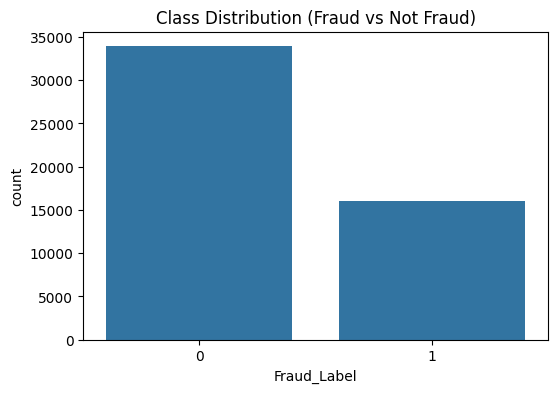

Fraudulent transactions percentage: 32.13%


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Fraud_Label', data=df)
plt.title("Class Distribution (Fraud vs Not Fraud)")
plt.show()

# Fraud percentage
fraud_rate = df['Fraud_Label'].mean() * 100
print(f"Fraudulent transactions percentage: {fraud_rate:.2f}%")


In [37]:
# drop no  useful columns
#df.drop(columns=['Transaction_ID'], inplace=True)
#df.drop(columns=['User_ID'], inplace=True)
df.drop(columns=['Timestamp'], inplace=True)

In [40]:
# encoding categorical columns
from sklearn.preprocessing import LabelEncoder
# Encode all object (string) columns
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders in case needed later


In [41]:
# feature selection

X=df.drop('Fraud_Label',axis=1)
y=df['Fraud_Label']


In [42]:
print("Feature Types: ",X.dtypes)

Feature Types:  Transaction_Amount              float64
Transaction_Type                  int64
Account_Balance                 float64
Device_Type                       int64
Location                          int64
Merchant_Category                 int64
IP_Address_Flag                   int64
Previous_Fraudulent_Activity      int64
Daily_Transaction_Count           int64
Avg_Transaction_Amount_7d       float64
Failed_Transaction_Count_7d       int64
Card_Type                         int64
Card_Age                          int64
Transaction_Distance            float64
Authentication_Method             int64
Risk_Score                      float64
Is_Weekend                        int64
dtype: object


In [43]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

🧠 What is SMOTE?
SMOTE stands for:

Synthetic Minority Over-sampling Technique

It’s used to fix imbalanced datasets by creating synthetic samples of the minority class (in our case, frauds).

✅ Use SMOTE when:

Target classes are highly imbalanced

Fraud, disease detection, churn prediction, etc.


In [44]:
# handle imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=42)
X_resampled,y_resampled=smote.fit_resample(X_scaled,y)

In [56]:
# train
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=42)



In [57]:
# model training

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Train Random Forest
rf=RandomForestClassifier(random_state=42,n_estimators=100)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)

In [58]:
# Train XGBoost
xgb=XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train,y_train)
xgb_pred=xgb.predict(X_test)

In [59]:
# evaluating both model

print(f"Classification Report: \n",classification_report(y_test,rf_pred))
print(f"\nROC-AUC Score: ",roc_auc_score(y_test,xgb_pred))



Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10151
           1       1.00      1.00      1.00     10209

    accuracy                           1.00     20360
   macro avg       1.00      1.00      1.00     20360
weighted avg       1.00      1.00      1.00     20360


ROC-AUC Score:  0.9984783737548519


In [60]:
# saving the model
joblib.dump(xgb,'model/fraud_detection_xgb_model.pkl')


['model/fraud_detection_xgb_model.pkl']

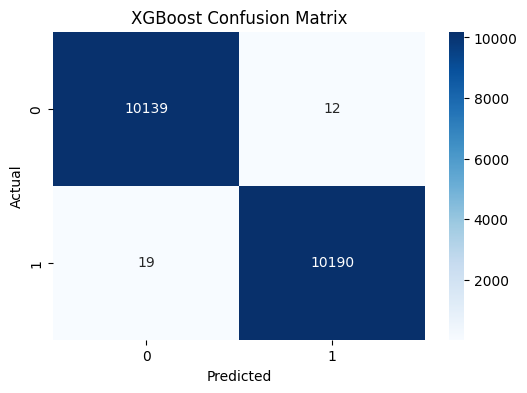

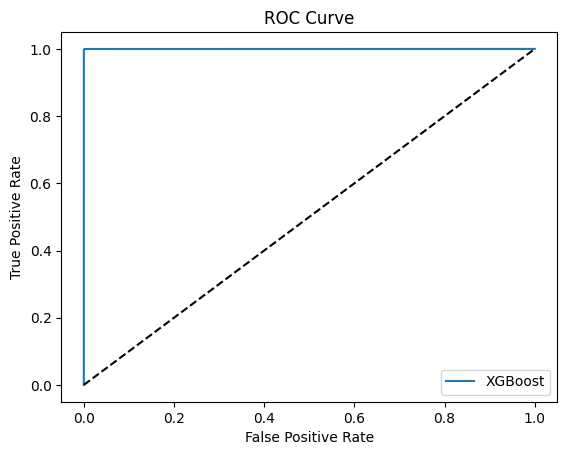

In [63]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
